<a href="https://colab.research.google.com/github/geraschenko/CME241/blob/main/assignments/assignment4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stanford CME 241 (Winter 2024) - Assignment 4

**Due: Feb 5 @ 11:59pm Pacific Time on Gradescope.**

Assignment instructions:
- **Please solve questions 1 and 2, and choose one of questions 3 or 4.**
- Empty code blocks are for your use. Feel free to create more under each section as needed.

Submission instructions:
- When complete, fill out your publicly available GitHub repo file URL and group members below, then export or print this .ipynb file to PDF and upload the PDF to Gradescope.

*Link to this ipynb file in your public GitHub repo (replace below URL with yours):*

https://github.com/geraschenko/CME241/blob/main/assignments/assignment4.ipynb

*Group members (replace below names with people in your group):*
- Anton Geraschenko
- Felipe Campos

## Imports

In [1]:
!pip install -q git+https://github.com/TikhonJelvis/RL-book.git

  Preparing metadata (setup.py) ... done


In [12]:
import matplotlib.pyplot as plt
import numpy as np

from typing import Iterator, Tuple, TypeVar, Sequence, List
from operator import itemgetter
from rl.distribution import Categorical, Choose
from rl.function_approx import FunctionApprox
from rl.iterate import iterate, converge, converged
from rl.markov_process import (FiniteMarkovRewardProcess, MarkovRewardProcess,
                               RewardTransition, NonTerminal, State)
from rl.markov_decision_process import (FiniteMarkovDecisionProcess,
                                        MarkovDecisionProcess,
                                        StateActionMapping)
from rl.function_approx import (Dynamic,
                                Tabular,
                                LinearFunctionApprox,
                                DNNApprox,
                                DNNSpec)
import rl.dynamic_programming
from rl.approximate_dynamic_programming import (
    evaluate_mrp,
    extended_vf,
    value_iteration,
    ValueFunctionApprox,
    NTStateDistribution,
    )
from rl.policy import DeterministicPolicy

S = TypeVar('S')
A = TypeVar('A')

## Question 1
Implement *Approximate Policy Iteration*, generalization of the tabular
Policy Iteration we covered in the previous class. In order to implement
Approximate Policy Iteration, first review the interface and
implementation of *Approximate Policy Evaluation* and *Approximate Value
Iteration* (in file
[rl/approximate_dynamic_programming.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/approximate_dynamic_programming.py)),
then design the interface of *Approximate Policy Iteration* to be the
same as that of *Approximate Value Iteration*. Note that your
implementation of *Approximate Policy Iteration* would need to invoke
*Approximate Policy Evaluation* since Policy Evaluation is a component
of Policy Iteration. Test that your implementation is correct in two
ways:

-   Ensure that *Approximate Policy Iteration* gives the same Optimal
    Value Function/Optimal Policy as that obtained by *Approximate Value
    Iteration*.

-   Ensure that *Approximate Policy Iteration* produces the same result
    as our prior implementation of Policy Iteration (in file
    [rl/dynamic_programming.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/dynamic_programming.py)).
    For this you need to pass to your implementation of *Approximate
    Policy Iteration* a `FiniteMarkovDecisionProcess` input and a
    `Tabular` instance for the `FunctionApprox` input.

In [3]:
def greedy_policy(mdp: MarkovDecisionProcess[S, A],
                  v: ValueFunctionApprox[S],
                  gamma: float
                 ) -> DeterministicPolicy[S, A]:
  def return_(s_r: Tuple[State[S], float]) -> float:
      s1, r = s_r
      return r + gamma * extended_vf(v, s1)

  def greedy_action(state: S) -> A:
    return max(
        (mdp.step(NonTerminal(state), a).expectation(return_), a)
        for a in mdp.actions(NonTerminal(state))
    )[1]

  return DeterministicPolicy(greedy_action)

def within(tolerance: float):
  def done(v1, v2):
    return v1.within(v2, tolerance)
  return done

def policy_iteration(
    mdp: MarkovDecisionProcess[S, A],
    gamma: float,
    approx_0: ValueFunctionApprox[S],
    non_terminal_states_distribution: NTStateDistribution[S],
    num_state_samples: int,
    policy_estimation_tolerance: float = 1e-2,
) -> Iterator[ValueFunctionApprox[S]]:

  def update(v: ValueFunctionApprox[S]) -> ValueFunctionApprox[S]:
    policy = greedy_policy(mdp, v, gamma)
    mrp = mdp.apply_policy(policy)
    return converged(evaluate_mrp(mrp, gamma, v, non_terminal_states_distribution, num_state_samples),
                     done=within(policy_estimation_tolerance))

  return iterate(update, approx_0)

In [4]:
def random_finite_mdp(states, actions, rng):
  mapping = {}
  for s in states:
    d = {}
    for a in actions:
      probs = rng.random(len(states))
      probs = probs / probs.sum()
      rewards = rng.random(len(states))
      d[a] = Categorical({(s1, r): p for s1, r, p in zip(states, rewards, probs)})
    mapping[s] = d
  return FiniteMarkovDecisionProcess(mapping)

In [5]:
# Set up an MDP and choose parameters for testing.
rng = np.random.default_rng(0)
states = list(range(3))
actions = ['a', 'b']
mdp = random_finite_mdp(states, actions, rng)
gamma = 0.99
nt_distribution = Choose(NonTerminal(s) for s in states)
num_state_samples = 100

### Compare to approximate value iteration

In [6]:
# Using Tabular instead of Dynamic doesn't work right for me. The values end up
# way too small, and are sensitive to the choice of num_state_samples. I must
# be misunderstanding something about Tabular.

approx_0 = Dynamic(values_map={NonTerminal(s): 0 for s in states})

In [22]:
%%time
v_value_iteration = converged(value_iteration(mdp, gamma, approx_0, nt_distribution, num_state_samples), within(1e-4))
print(v_value_iteration)
p = greedy_policy(mdp, v_value_iteration, gamma)
print({s: p.act(NonTerminal(s)) for s in states})

Dynamic(values_map={NonTerminal(state=0): 61.672008906350015, NonTerminal(state=1): 61.50356865684704, NonTerminal(state=2): 61.89004437222002})
{0: Constant(value='b'), 1: Constant(value='a'), 2: Constant(value='a')}
CPU times: user 196 ms, sys: 993 µs, total: 197 ms
Wall time: 211 ms


In [ ]:
# This is so slow! I reduced num_state_samples to speed it up a bit.
num_state_samples = 10
v_policy_iteration = converged(policy_iteration(mdp, gamma, approx_0, nt_distribution, num_state_samples), within(1e-3))

In [21]:
print(v_policy_iteration)
p = greedy_policy(mdp, v_policy_iteration, gamma)
print({s: p.act(NonTerminal(s)) for s in states})

Dynamic(values_map={NonTerminal(state=0): 61.618736600199554, NonTerminal(state=1): 61.45324308399359, NonTerminal(state=2): 61.84072809164283})
{0: Constant(value='b'), 1: Constant(value='a'), 2: Constant(value='a')}


In [24]:
assert v_value_iteration.within(v_policy_iteration, 1e-1)

### Compare to finite policy iteration


In [25]:
def done(v_pi1, v_pi2):
  v1 = v_pi1[0]
  v2 = v_pi2[0]
  return all(abs(v1[s] - v2[s]) < 1e-4 for s in v1.keys())

v_finite_policy_iteration, policy = converged(rl.dynamic_programming.policy_iteration(mdp, gamma), done)
v_finite_policy_iteration

{NonTerminal(state=0): 61.68095215611541,
 NonTerminal(state=1): 61.51241262034812,
 NonTerminal(state=2): 61.8988883357211}

In [28]:
assert all(abs(v_policy_iteration(s) - val) < 1e-1 for s, val in v_finite_policy_iteration.items())

## Question 2
Assume the Utility function is $U(x) = x - \frac {\alpha x^2} 2$.
Assuming $x \sim \mathcal{N}(\mu, \sigma^2)$, calculate:

-   Expected Utility $\mathbb{E}[U(x)]$

-   Certainty-Equivalent Value $x_{CE}$

-   Absolute Risk-Premium $\pi_A$


Assume you have a million dollars to invest for a year and you are
allowed to invest $z$ dollars in a risky asset whose annual return on
investment is $\mathcal{N}(\mu, \sigma^2)$ and the remaining (a million
minus $z$ dollars) would need to be invested in a riskless asset with
fixed annual return on investment of $r$. You are not allowed to adjust
the quantities invested in the risky and riskless assets after your
initial investment decision at time $t=0$ (static asset allocation
problem). If your risk-aversion is based on this Utility function, how
much would you invest in the risky asset? In other words, what is the
optimal value for $z$, given your level of risk-aversion (determined by
a fixed value of $\alpha$)?

Plot how the optimal value of $z$ varies with $\alpha$.

---
The expected utility is
$$
\newcommand\N{\mathcal N}
\newcommand\E{\mathbb E}
\begin{align*}
\E[U(x)] &= \E[x - \alpha x^2/2]\\
  &= \E[(1 - \alpha\mu)(x-\mu) - \alpha (x-\mu)^2/2 + (1-\alpha\mu/2)\mu] \\
  &=  (1 - \alpha\mu) \underbrace{\E[x-\mu]}_{=0} - \alpha \underbrace{\E[(x-\mu)^2]}_{=\sigma^2}/2 + (1-\alpha\mu/2)\mu \\
  &= \mu - \frac{\alpha(\sigma^2  + \mu^2)}2
\end{align*}$$

---
The certainty-equivalent value must therefore satisfy $U(x_{CE}) = x_{CE} - \alpha x_{CE}^2/2 = \mu - \frac{\alpha(\sigma^2  + \mu^2)}2$, which we can solve for with the quadratic formula (we'll just take the positive square root, assuming $\mu$ is positive, and that we're interested in the certainty-equivalent value closest to it):
$$
x_{CE}^2 - \frac 2\alpha x_{CE} + \frac{2\mu}{\alpha} - (\sigma^2+\mu^2) = 0 \\
\begin{align*}
x_{CE} &= \frac 1\alpha + \sqrt{\frac{1}{\alpha^2} - \frac{2\mu}{\alpha} + (\sigma^2 + \mu^2)} \\
  &= \frac 1\alpha + \sqrt{\bigl(\mu - \frac 1\alpha\bigr)^2 + \sigma^2}
\end{align*}
$$


---
The absolute risk premium is
$$
\pi_A = \mu - x_{CE} = \bigl(\mu - \frac 1\alpha\bigr) - \sqrt{\bigl(\mu - \frac 1\alpha\bigr)^2 + \sigma^2}
$$

---
If we invest $z$ in this asset and $W - z$ into a riskless asset with rate of return $r$, then our wealth a year out will be normally distributed with mean $((1+\mu)z + (1+r)(W - z) = W(1 + r) + z(\mu - r)$ and variance $\sigma^2 z$. Applying the formula for expected utility above (and avoiding getting confused about the overloaded symbols "$\mu$" and "$\sigma$"), we have that our expected utility after a year is
$$
W(1+r) + z(\mu - r) - \frac\alpha 2(z\sigma^2 + (W(1+r) + z(\mu - r))^2)
$$
Setting the derivative with respect to $z$ to zero, we have that the optimal $z$ satisfies
$$\begin{align*}
0 &= (\mu - r) - \frac\alpha 2(\sigma^2 + 2(W(1+r) + z^*(\mu - r))(\mu - r))\\
  &= (\mu - r) - \alpha\sigma^2/2 - \alpha W(1+r)(\mu - r) - \alpha z^* (\mu -r)^2
\end{align*}$$
so
$$
\boxed{z^* =\frac{1}{\mu - r}\Bigl(\frac{1}{\alpha} - \frac{\sigma^2}{2(\mu - r)} - W(1+r)\Bigr)}
$$
The second derivative of expected utility with respect to $z$ is $-\alpha(\mu - r)^2$, which is negative so long as $\alpha$ is positive, so this critical point is a maximum.

Let's spot check when $W=0$ and $\sigma^2=0$. Investing $z$ gets a gauranteed value of $(\mu - r)z$ after a year. The value of $x$ which maximizes utility is $x = 1/\alpha$, so indeed $z^* = \frac{1}{(\mu - r)\alpha}$ is optimal. The formula for $z^*$ is confusing to me, so I'll also check it numerically below.

In [29]:
def expected_utility(alpha, mean, var):
  return mean - alpha * (var + mean**2) / 2

def outcome(W, z, r, mu, sigma):
  mean = W * (1 + r) + z * (mu - r)
  var = np.abs(z * sigma**2)
  return mean, var

def z_star(alpha, W, r, mu, sigma):
  return (1 / alpha - sigma**2 / (2 * (mu - r)) - W * (1 + r)) / (mu - r)

In [30]:
W = 1000000
r = 0.05
mu = 0.1
sigma = 0.07
# Note: wealth 1 / alpha maximizes utility, so if W is within a factor of 1+r
# exceeding 1 / alpha, the optimal behavior is to try to *lose* money.
alpha = np.logspace(np.log10(1e-7), np.log10(1 / W), 100)
z_best = z_star(alpha, W, r, mu, sigma)

# I'm suspicious of my derived formula for z^*, so let's also check it numerically.
z = np.logspace(np.log10(1), np.log10(1e9), 1000)
mean, var = outcome(W, z, r, mu, sigma)
exp_u = expected_utility(alpha[:, np.newaxis], mean, var)  # dimensions [alpha, z]
z_best_numerical = z[np.argmax(exp_u, axis=1)]

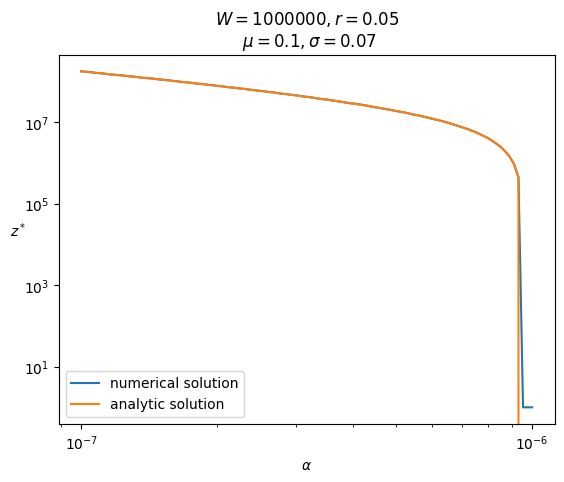

In [31]:
plt.plot(alpha, z_best_numerical, label='numerical solution')
plt.plot(alpha, z_best, label='analytic solution')
plt.xscale('log')
plt.yscale('log')
plt.title(f'$W={W}, r={r}$\n $\mu={mu}, \sigma={sigma}$')
plt.xlabel('$\\alpha$')
plt.ylabel('$z^*$', rotation=0)
plt.legend();

## Question 3

Assume you are playing a casino game where at every turn, if you bet a
quantity $x$, you will be returned $x \cdot (1 + \alpha)$ with
probability $p$ and returned $x \cdot (1 - \beta)$ with probability
$q = 1 - p$ for $\alpha, \beta \in \mathbb{R}^+$ (i.e., the return on
bet is $\alpha$ with probability $p$ and $-\beta$ with probability
$q = 1-p$) . The problem is to identify a betting strategy that will
maximize one's expected wealth over the long run. The optimal solution
to this problem is known as the Kelly criterion, which involves betting
a constant fraction of one's wealth at each turn (let us denote this
optimal fraction as $f^*$).

It is known that the Kelly criterion (formula for $f^*$) is equivalent
to maximizing the Expected Utility of Wealth after a single bet, with
the Utility function defined as: $U(W) = \log(W)$. Denote your wealth
before placing the single bet as $W_0$. Let $f$ be the fraction (to be
solved for) of $W_0$ that you will bet. Therefore, your bet is
$f \cdot W_0$.

-   Write down the two outcomes for wealth $W$ at the end of your single bet of $f \cdot W_0$.

-   Write down the two outcomes for $\log$ (Utility) of $W$.

-   Write down $\mathbb{E}[\log(W)]$.

-   Take the derivative of $\mathbb{E}[\log(W)]$ with respect to $f$.

-   Set this derivative to 0 to solve for $f^*$. Verify that this is indeed a maxima by evaluating the second derivative at $f^*$. This formula for $f^*$ is known as the Kelly Criterion.

-   Convince yourself that this formula for $f^*$ makes intuitive sense (in terms of it's dependency on $\alpha$, $\beta$ and $p$).


---
The amount you _don't_ bet, $W_0(1-f)$, remains unchanged, so the outcomes are
* $W_0(f(1+\alpha) + (1 - f)) = W_0(1 + f\alpha)$ with probability $p$, and  
* $W_0(f(1-\beta) + (1 - f)) = W_0(1 - f\beta)$ with probability $1 - p$.

The outcomes for utility of $W$ are
* $\log(W_0) + \log(1 + f\alpha)$ with probability $p$, and  
* $\log(W_0) + \log(1 - f\beta)$ with probability $1 - p$.

---
The expected utility and its first two derivatives are therefore
$$\begin{align*}
\E[\log(W)] &= \log W_0 + p\log(1 + f\alpha) + (1-p)\log(1 - f\beta) \\
\frac{d}{df} \E[\log(W)] &= p\frac{\alpha}{1 + f\alpha} - (1-p)\frac{\beta}{1-f\beta} \\
\frac{d^2}{df^2} \E[\log(W)] &= -p\frac{\alpha^2}{(1 + f\alpha)^2} - (1-p)\frac{\beta^2}{(1-f\beta)^2}
\end{align*}$$
Setting the derivative to 0, we have that $f^*$ satisfies
$$\begin{align*}
p\frac{\alpha}{1 + f^*\alpha} &= (1-p)\frac{\beta}{1-f^*\beta} \\
p\alpha(1 - f^*\beta) &= (1-p)\beta(1+f^*\alpha) \\
p\alpha - (1 - p)\beta &= f^*(p\alpha\beta + \alpha\beta - p\alpha\beta) \\
& \hspace{-3ex}\boxed{f^* = \frac{p}{\beta} - \frac{(1 - p)}{\alpha}}
\end{align*}
$$
So long as $p$ is not 0 or 1, this $f^*$ is strictly between $-\frac 1\alpha$ and $\frac 1\beta$, so for this value of $f$ all the squares in the formula for the second derivative are positive. Since $p$ and $1-p$ are also positive, the second derivative is strictly negative, so this critical point is a maximum.

This $f^*$ makes sense:
* It is between $-\frac 1\alpha$ and $\frac 1\beta$, because betting a fraction smaller than $-\frac 1\alpha$ or greater than $\frac 1\beta$ could result in your wealth dropping to or below 0, which a logarithmic utility function regards as infinitely bad.
  * For $\alpha > 0$, "betting $-\frac 1\alpha$" means you act as the casino, offering the bet to somebody putting up $W_0/\alpha$. If they win, you return the money they put up plus $W_0$, leaving you with nothing.
  * For $\beta > 1$, "betting $\frac 1\beta$" means taking out a loan for $(\frac 1 \beta - 1)W_0$ and betting it all (along with your original $W_0$). If you lose, then you're left with just enough money to pay back your loan and be left with nothing.
* The closer $p$ is to 1 (i.e. the more certain the win), the larger a fraction we bet, and the closer $p$ is to 0, the smaller a fraction we bet.
* If $p\alpha = (1-p)\beta$, then the bet has the same expected value as just holding your money, but it comes with non-zero variance. Since our utility function is concave, it makes sense that $f^*$ is zero in this case.

## Question 4

Derive the solution to Merton's Portfolio problem for the case of the
$\log(\cdot)$ Utility function. Note that the derivation in the textbook
is for CRRA Utility function with $\gamma \neq 1$ and the case of the
$\log(\cdot)$ Utility function was left as an exercise to the reader.

---
First we recall the setup.
* There's a riskless asset with return rate $r$, and one risky asset with mean return rate $\mu$ and variance rate $\sigma^2$.
* $W_t$ is a random variable denoting our wealth at time $t$.
* $\pi_t = \pi(t, W_t)$ denotes the proportion of our wealth in the risky asset at time $t$.
* $c_t = c(t, W_t)$ denotes the amount of wealth consumed per unit time at time $t$.
* $U(x)$ denotes our utility *per unit time* of consuming wealth $x$ *per unit time*. <font color=#FF0000>**[This is a little weird. Note that the bequest function converts to *absolute* utility of the final amount]**</font>.
* $\rho$ denotes our discount rate of utility.
* We aim to bequest nothing, so we'll take the bequest function to be $\varepsilon$ for some $0 < \varepsilon \ll 1$. That is, the utility we get at time $T$ is $\varepsilon \log(W_T)$.

Our wealth is an It&ocirc; process satisfying
$$
dW_t = \bigl((r + \pi_t (\mu - r))W_t - c_t \bigr)dt + \pi_t W_t\sigma dz_t
$$
We wish to solve for the optimal value function $V^* = V^*(t, W_t)$, along with the optimal allocation and consumption functions $(\pi^*_t, c^*_t)$. The solution must satisfy the HJB equation
$$
\rho V^* dt = \max_{\pi_t, c_t}\E[U(c_t)dt + dV^*]
\tag{HJB}
$$
By It&ocirc;'s lemma, we have
$$\begin{align*}
dV^* &= \Bigl(\partial_t V^* + \partial_W V^* \bigl((r + \pi_t(\mu - r))W_t - c_t\bigr) + \frac 12 \partial_W^2 V^* \pi_t^2W_t^2\sigma^2\Bigr)dt + \underbrace{\partial_W V^* \pi_t W_t \sigma dz_t}_{\text{expectation 0}}
\tag{Ito}
\end{align*}$$
We determine the optimal $\pi_t$ and $c_t$ by finding critical points of $\E[U(c_t)dt + dV^*]$ with respect to those quantities. Setting the derivative with respect to $c_t$ to zero, we have
$$
U'(c_t^*) = \partial_W V^*
$$
Since $U(x) = \log(x)$, we have $U'(x) = 1/x$, so
$$
c_t^* = \frac{1}{\partial_W V^*}
\tag{c}
$$

Setting the derivative with respect to $\pi_t$ to zero, we have
$$
\partial_W V^* (\mu - r)W_t +  \partial_W^2 V^* \pi_t^* W_t^2 \sigma^2 = 0
$$
$$
\pi_t^* = -\frac{\mu - r}{\sigma^2}\cdot \frac{\partial_W V^*}{W_t\partial_W^2 V^*} \tag{$\pi$}
$$

Plugging these values of $c_t^*$ and $\pi_t^*$ into equation (Ito), and plugging that into equation (HJB), we have that $V^*$ satisfies the PDE
$$\begin{align*}
\rho V^* &= -\log(\partial_W V^*) + \partial_t V^* + \partial_W V^* \Bigl(rW_t -\frac{(\mu - r)^2}{\sigma^2}\cdot \frac{\partial_W V^*}{\partial_W^2 V^*} - \frac{1}{\partial_W V^*}\Bigr) + \frac 12  \frac{(\mu - r)^2}{\sigma^2}\cdot \frac{(\partial_W V^*)^2}{\partial_W^2 V^*}
\end{align*}$$
and is subject to the boundary condition
$$
V^*(T, W_T) = \varepsilon \log(W_T)
$$

Let's take a guess that $V^*$ is of the form
$$
V^*(t, W_t) = g(t) + f(t) \log(W_t)
$$
for some functions $g(t)$ and $f(t)$, which are subject to the bounardy conditions $g(T) = 0$, $f(T) = \varepsilon$. We then have that
$$\begin{align*}
\partial_t V^* &= g' + f'\log W_t \\
\partial_W V^* &= \frac{f}{W_t}\\
\partial_W^2 V^* &= -\frac{f}{W_t^2}
\end{align*}$$
Plugging this into the PDE above, we have
$$
\rho g + \rho f \log W = \log W - \log f + g' + f'\log W + \underbrace{\Bigl( r + \frac{(\mu - r)^2}{2\sigma^2}\Bigr)}_{\nu}f - 1
$$
Let's define $\nu$ to be the braced quantity.

If we choose
$$
f(t) = \begin{cases}
  (1 + (\rho\varepsilon - 1)e^{\rho (t - T)})/\rho & \text{if }\rho \neq 0\\
  T-t + \varepsilon & \text{if }\rho = 0
\end{cases}$$
then it satisfies $f' = \rho f - 1$ and $f(T) = \varepsilon$, so the equation simplifies to something with no dependence on $W_t$:
$$
\rho g = g' -\log f + \nu f - 1\\
g' = \rho g + 1 + \log f - \nu f
$$
which we subject to the boundary condition $g(T) = 0$ to make the bequest work out.

If $\rho = 0$, this is solved by
$$
g(t) = \frac \nu 2 (T - t + \varepsilon)^2 - (T - t + \varepsilon)\log(T - t + \varepsilon) + \varepsilon\log \varepsilon - \frac{\nu \varepsilon^2}{2}
$$
so we have
$$\begin{align*}
V^*(t, W_t) &= \frac \nu 2 (T - t + \varepsilon)^2 - (T - t + \varepsilon)\log(T - t + \varepsilon) + \varepsilon\log \varepsilon - \frac{\nu \varepsilon^2}{2} + (T - t + \varepsilon)\log(W_t) \\
c^*(t, W_t) &= \frac{W_t}{(T - t + \varepsilon)} \\
\pi^*(t, W_t) &= \frac{\mu - r}{\sigma^2}
\end{align*}$$

If $\rho \neq 0$, $g$ is some other function which I don't want to solve for, but $c^*$ and $\pi^*$ only depend on the derivatives of $V^*$ with respect to $W_t$, which do not depend on whatever $g$ works out to be. They are
$$\begin{align*}
c^*(t, W_t) &= \frac{W_t \rho}{1 + (\rho\varepsilon - 1)e^{\rho (t - T)}} \\
\pi^*(t, W_t) &= \frac{\mu - r}{\sigma^2}
\end{align*}$$